In [16]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Neural Network for DQN
class DQNNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQNNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 24)
        self.fc2 = nn.Linear(24, 48)
        self.fc3 = nn.Linear(48, action_size)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)  # Outputs Q-values for all actions
        
# Priority Replay Buffer
class PriorityReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
        self.priorities = deque(maxlen=capacity)

    def add(self, experience, priority):
        self.buffer.append(experience)
        self.priorities.append(priority)

    def sample(self, batch_size):
        probabilities = np.array(self.priorities) / sum(self.priorities)
        indices = np.random.choice(range(len(self.buffer)), batch_size, p=probabilities)
        experiences = [self.buffer[idx] for idx in indices]
        return experiences

    def size(self):
        return len(self.buffer)
    
    
    def get_importance_weights(self, b=0.4, epsilon=1e-5):
        sampling_probabilities = np.array(self.priorities) / sum(self.priorities)
        importance_weights = (1 / (len(self.buffer) * sampling_probabilities + epsilon)) ** b
        return importance_weights

# Agent
class Agent:
    def __init__(self, state_size, action_size, batch_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = PriorityReplayBuffer(10000)
        self.batch_size = batch_size
        self.gamma = 0.99  # discount factor
        self.epsilon = 0.5  # exploration rate
        self.epsilon_decay = 1
        self.epsilon_min = 0.01
        self.model = DQNNetwork(state_size, action_size)
        self.target_model = DQNNetwork(state_size, action_size).to(device)
        self.update_target_model()
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.action_values = transform_action_values(action_size)
        self.model = DQNNetwork(state_size, action_size).to(device)

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def select_action(self, state):
        # Extract the state array if it's inside a tuple
        if isinstance(state, tuple):
            state = state[0]

        # Ensure the state is a numpy array and reshape it to (1x3)
        state = np.array(state).reshape(1, -1)

        # Convert the state to a tensor
        state_tensor = torch.FloatTensor(state).to(device)

        with torch.no_grad():
            # Get Q-values from the network for the current state
            q_values = self.model(state_tensor)

        # Epsilon-greedy policy for exploration-exploitation trade-off
        if np.random.rand() > self.epsilon:
            # Exploitation: choose the best action based on Q-values
            action_index = torch.argmax(q_values).item()
            action = self.action_values[action_index]
        else:
            # Exploration: choose a random action
            action_index = np.random.randint(len(self.action_values))
            action = self.action_values[action_index]

        # Decay the epsilon value (if applicable)
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

        return [action]

    def store_experience(self, state, action, reward, next_state, done):
        # Extract the state array if it's inside a tuple
        if isinstance(state, tuple):
            state = state[0]

        # Ensure the state and next_state are numpy arrays
        if not isinstance(state, np.ndarray):
            state = np.array(state)
        if not isinstance(next_state, np.ndarray):
            next_state = np.array(next_state)

        # Convert to tensors
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0).to(device)
        action_tensor = torch.FloatTensor([action]).unsqueeze(0).to(device)

    def update_network(self):
        if self.memory.size() < self.batch_size:
            return

        experiences = self.memory.sample(self.batch_size)
        importance_weights = torch.FloatTensor(self.memory.get_importance_weights()).to(device)

        # Batch processing
        states, actions, rewards, next_states, dones = zip(*experiences)
        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).to(device)

        # Compute Q values
        current_q_values = self.model(states).gather(1, actions)
        next_q_values = self.target_model(next_states).detach().max(1)[0].unsqueeze(1)
        expected_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        # Compute loss
        loss = (current_q_values - expected_q_values).pow(2) * importance_weights
        loss = loss.mean()

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def calculate_priority(self, state, action, reward, next_state, done):
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        # next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0).to(device)
        # action_tensor = torch.FloatTensor([action]).unsqueeze(0).to(device)

        with torch.no_grad():
            current_q = self.model(state_tensor)[0][action]
            max_next_q = torch.max(self.target_model(next_state)).item()
            expected_q = reward + self.gamma * max_next_q * (not done)

        td_error = abs(current_q - expected_q)
        epsilon = 0.01  # Small constant
        alpha = 0.6     # Degree of prioritization
        priority = (td_error + epsilon) ** alpha
        return priority

def transform_action_values(n_actions, min_action=-2.0, max_action=2.0):
    # Linearly spaced values between -1 and 1
    linear_actions = np.linspace(-1, 1, n_actions)

    # Apply a quadratic transformation
    non_linear_actions = np.sign(linear_actions) * (linear_actions ** 2)

    # Scale to the action range of the environment
    scaled_actions = min_action + (non_linear_actions + 1) * (max_action - min_action) / 2
    return scaled_actions

def run_test_episodes(env, agent, num_episodes=10):
    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        for EP in range(200):
            env.render()
            action = agent.select_action(state)
            next_state, reward, done, _, _ = env.step(action)
            state = next_state
            total_reward += reward
            if done:
                break
        print(f"Test Episode {episode+1}/{num_episodes}, Total Reward: {total_reward}")
    env.close()


In [18]:
import matplotlib.pyplot as plt

if __name__ == "__main__":
    env = gym.make('Pendulum-v1', g=9.81, render_mode="rgb_array")
    state_size = env.observation_space.shape[0]
    action_size = 6  # Discretize action space into 30 actions

    agent = Agent(state_size, action_size, batch_size=128)

    scores = []  # List to store scores
    num_episodes = 100000  # Number of episodes to train

    for episode in range(num_episodes):
        state, info = env.reset()
        total_reward = 0
        total_custom = 0

        for t in range(200):
            action = agent.select_action(state)
            next_state, reward, done, _, _ = env.step(action)
            state_array = state[0] if isinstance(state, tuple) else state
            next_state_array = next_state[0] if isinstance(next_state, tuple) else next_state

            # Now calculate the custom_reward using the numpy arrays
            custom_reward = 25 * np.exp(-1 * (next_state_array[0] - 1) ** 2 / 0.001) - 100 * np.abs(10 * 0.5 - (10 * 0.5 * next_state_array[0] + 0.5 * 0.3333 * next_state_array[2] ** 2)) + 100 * np.abs(10 * 0.5 - (10 * 0.5 * state_array[0] + 0.5 * 0.3333 * state_array[2] ** 2))
            agent.store_experience(state, action, reward, next_state, done)
            agent.update_network()
            state = next_state
            total_reward += reward
            total_custom += custom_reward

            if done:
                break

        scores.append(total_reward)  # Store score for plotting
        print(f"Episode {episode+1}/{num_episodes}, Total Reward: {total_reward} Total Reward:{total_custom} ")

        # Update the target network
        if episode % 10 == 0:
            agent.update_target_model()

    env.close()

    # Saving the model
    torch.save(agent.model.state_dict(), 'pendulum_dqn_model.pth')



Episode 1/100000, Total Reward: -1346.2067890539656 Total Reward:51.18371558776596 
Episode 2/100000, Total Reward: -1314.476580700603 Total Reward:-307.53837237529535 
Episode 3/100000, Total Reward: -1526.5062040456694 Total Reward:54.20794757546537 
Episode 4/100000, Total Reward: -1262.4135607148285 Total Reward:-513.2620501632833 
Episode 5/100000, Total Reward: -1549.1093069644567 Total Reward:-122.21102707039665 
Episode 6/100000, Total Reward: -1355.1876614129103 Total Reward:-348.60466305557696 
Episode 7/100000, Total Reward: -1198.6218123492908 Total Reward:-712.4170915995899 
Episode 8/100000, Total Reward: -913.2829603671395 Total Reward:54.694575143364744 
Episode 9/100000, Total Reward: -1353.9726700755862 Total Reward:-107.42553847539102 
Episode 10/100000, Total Reward: -944.4985246866725 Total Reward:-82.60794326603246 
Episode 11/100000, Total Reward: -1262.3206871251105 Total Reward:-142.28768505001983 
Episode 12/100000, Total Reward: -1379.4980103793812 Total Rewa

KeyboardInterrupt: 

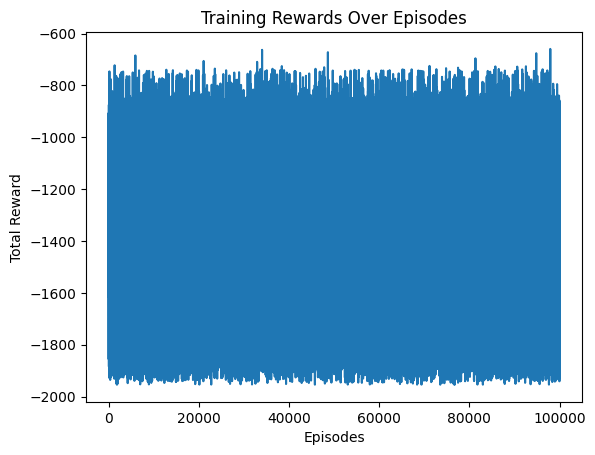

In [ ]:
# Plotting the scores
plt.plot(scores)
plt.title('Training Rewards Over Episodes')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.show()

In [ ]:
env = gym.make('Pendulum-v1', g=9.81, render_mode="human")
state_size = env.observation_space.shape[0]
action_size = 6  # Discretize action space into 30 actions

agent = Agent(state_size, action_size, batch_size=128)

run_test_episodes(env, agent, num_episodes=10)

Test Episode 1/10, Total Reward: -1448.8029389042536
Test Episode 2/10, Total Reward: -1590.100078652469
Test Episode 3/10, Total Reward: -1523.1296905644163


KeyboardInterrupt: 